# 0. Parsing XML files and converting them to dataframes

We first need to parse the XML files and save the data to CSV.

For that, we have to know how XML files look. The library xml.etree.ElementTree helps us [...]

In [1]:
import pandas as pd
import xml.etree.ElementTree as ET

def parse_posts_with_tags(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    data = []
    for elem in root:
        row = elem.attrib.copy()

        tag_str = row.get("Tags", "")
        tags = tag_str.strip("|").split("|") if tag_str else []
        row["Tags"] = tags

        data.append(row)

    df = pd.DataFrame(data)
    return df

In [2]:
df_raw = parse_posts_with_tags('xml_data/Posts.xml')

# 1. Data inspection, EDA, cleaning and preprocessing.

Let's see the columns

In [3]:
df_raw.columns

Index(['Id', 'PostTypeId', 'AcceptedAnswerId', 'CreationDate', 'Score',
       'ViewCount', 'Body', 'OwnerUserId', 'LastEditorUserId', 'LastEditDate',
       'LastActivityDate', 'Title', 'Tags', 'AnswerCount', 'CommentCount',
       'ContentLicense', 'ParentId', 'ClosedDate', 'FavoriteCount',
       'CommunityOwnedDate', 'LastEditorDisplayName', 'OwnerDisplayName'],
      dtype='object')

We only want to conserve the columns that bring us information about the possible tags included.
- OwnerUserId (Certain post owners might gravitate towards certain topics, hence use the same tags)
- Title (The title can contain useful info too)
- Body (Trivial)
- TAGS (Label[s]) (Target variable)

### INITIAL SELECTION

In [4]:
df_raw = df_raw[['OwnerUserId','Title','Body','Tags']]

In [5]:
df_raw.head(10)

,OwnerUserId,Title,Body,Tags
0,8,"What is ""backprop""?","<p>What does ""backprop"" mean? Is the ""backprop...","[neural-networks, backpropagation, terminology..."
1,8,How does noise affect generalization?,<p>Does increasing the noise in data help to i...,"[neural-networks, machine-learning, statistica..."
2,4,NaN,"<p>""Backprop"" is the same as ""backpropagation""...",[]
3,8,How to find the optimal number of neurons per ...,"<p>When you're writing your algorithm, how do ...","[neural-networks, hyperparameter-optimization,..."
4,29,Are humans intelligent according to the defini...,<p>Given the following definition of an intell...,"[philosophy, definitions, intelligent-agent]"
5,26,"Why does Stephen Hawking say ""Artificial Intel...","<p>This <a href=""https://www.independent.co.uk...","[agi, superintelligence, singularity, ai-safet..."
6,4,NaN,"<p>Noise in the data, to a reasonable amount, ...",[]
7,8,What is fuzzy logic?,<p>I'm new to A.I. and I'd like to know in sim...,"[deep-neural-networks, terminology, fuzzy-logic]"
8,10,NaN,<p>We typically think of machine learning mode...,[]
9,4,NaN,<p>There is no direct way to find the optimal ...,[]


Some of the rows have an empty tag list, so we should remove those

In [6]:
df_raw = df_raw[df_raw['Tags'].apply(lambda x: len(x) > 0)].reset_index(drop=True)

In [7]:
df_raw.head(10)

,OwnerUserId,Title,Body,Tags
0,8,"What is ""backprop""?","<p>What does ""backprop"" mean? Is the ""backprop...","[neural-networks, backpropagation, terminology..."
1,8,How does noise affect generalization?,<p>Does increasing the noise in data help to i...,"[neural-networks, machine-learning, statistica..."
2,8,How to find the optimal number of neurons per ...,"<p>When you're writing your algorithm, how do ...","[neural-networks, hyperparameter-optimization,..."
3,29,Are humans intelligent according to the defini...,<p>Given the following definition of an intell...,"[philosophy, definitions, intelligent-agent]"
4,26,"Why does Stephen Hawking say ""Artificial Intel...","<p>This <a href=""https://www.independent.co.uk...","[agi, superintelligence, singularity, ai-safet..."
5,8,What is fuzzy logic?,<p>I'm new to A.I. and I'd like to know in sim...,"[deep-neural-networks, terminology, fuzzy-logic]"
6,38,Can a single neural network handle recognizing...,"<p>In particular, an embedded computer (with l...","[neural-networks, image-recognition]"
7,9,"Is the Turing Test, or any of its variants, a ...","<p>The <a href=""https://en.wikipedia.org/wiki/...","[turing-test, agi, intelligent-agent, narrow-ai]"
8,8,"What is ""early stopping"" in machine learning?","<p>What is <a href=""https://en.wikipedia.org/w...","[deep-learning, definitions, overfitting, regu..."
9,55,What is the concept of the technological singu...,<p>I've heard the idea of the technological si...,"[philosophy, definitions, agi, superintelligen..."


Next, because some posts don't have titles, we turn to concatenating the title and body columns into a single content column.

In [8]:
import html

df_raw['Body'] = df_raw['Body'].apply(lambda x: html.unescape(x) if isinstance(x, str) else "")
df_raw['Title'] = df_raw['Title'].fillna("")

df_raw['Content'] = df_raw['Title'] + " " + df_raw['Body']

df_raw.drop(columns=['Title','Body'])

df_raw = df_raw[['OwnerUserId','Content','Tags']]

df_raw.head(10)

,OwnerUserId,Content,Tags
0,8,"What is ""backprop""? <p>What does ""backprop"" me...","[neural-networks, backpropagation, terminology..."
1,8,How does noise affect generalization? <p>Does ...,"[neural-networks, machine-learning, statistica..."
2,8,How to find the optimal number of neurons per ...,"[neural-networks, hyperparameter-optimization,..."
3,29,Are humans intelligent according to the defini...,"[philosophy, definitions, intelligent-agent]"
4,26,"Why does Stephen Hawking say ""Artificial Intel...","[agi, superintelligence, singularity, ai-safet..."
5,8,What is fuzzy logic? <p>I'm new to A.I. and I'...,"[deep-neural-networks, terminology, fuzzy-logic]"
6,38,Can a single neural network handle recognizing...,"[neural-networks, image-recognition]"
7,9,"Is the Turing Test, or any of its variants, a ...","[turing-test, agi, intelligent-agent, narrow-ai]"
8,8,"What is ""early stopping"" in machine learning? ...","[deep-learning, definitions, overfitting, regu..."
9,55,What is the concept of the technological singu...,"[philosophy, definitions, agi, superintelligen..."


Let's turn to inspecting how this new column Content looks by picking a few 

In [9]:
df_raw.shape

(12380, 3)

There are a total of 12380 posts which have at least 1 tag.

In [10]:
print(df_raw.loc[0,'Content'])
print(df_raw.loc[1,'Content'])

What is "backprop"? <p>What does "backprop" mean? Is the "backprop" term basically the same as "backpropagation" or does it have a different meaning?</p>

How does noise affect generalization? <p>Does increasing the noise in data help to improve the learning ability of a network? Does it make any difference or does it depend on the problem being solved? How is it affect the generalization process overall?</p>



Clearly, the bodies of text contain html tags that need to be removed in order to move forward to tokenization (with/without n-grams), lemmatization/stemming and further preprocessing before we move onto multilabel binarizing and training our models.

In [11]:
from bs4 import BeautifulSoup

df_raw['Content'] = df_raw['Content'].apply(lambda x: BeautifulSoup(x, "html.parser").get_text())

In [12]:
df_raw['Content']

0        What is "backprop"? What does "backprop" mean?...
1        How does noise affect generalization? Does inc...
2        How to find the optimal number of neurons per ...
3        Are humans intelligent according to the defini...
4        Why does Stephen Hawking say "Artificial Intel...
                               ...                        
12375    Time complexity of BFS in O(b^n) - Constant of...
12376    Transformers Decoder Inputs (Keys and Values) ...
12377    Clarification on T5 Model Pre-training Objecti...
12378    LLMs as "fuzzy JPEGs" We should\n\nconceptuali...
12379    Influence of Unused FFN on Model Accuracy in P...
Name: Content, Length: 12380, dtype: object

### TAG SELECTION

Now we can move along to sorting the tags by frequency and seeing how many tags account for a certain percentage (aka the Pareto principle - 80% of outcomes are from about 20% of causes)

In [13]:
from collections import Counter

all_tags = []

for tag_list in df_raw['Tags']:
    for tag in tag_list:
        all_tags.append(tag)

tag_counts = Counter(all_tags)

sorted_tags = tag_counts.most_common()

df_tag_counts = pd.DataFrame(sorted_tags, columns=['Tag', 'Count'])

display(df_tag_counts.head(df_tag_counts['Tag'].nunique()))

,Tag,Count
0,neural-networks,2600
1,reinforcement-learning,2462
2,machine-learning,2354
3,deep-learning,2021
4,convolutional-neural-networks,1179
...,...,...
981,gini-impurity,1
982,next-frame-video-prediction,1
983,video-generation,1
984,mistral,1


In [14]:
df_tag_counts.head(20)

,Tag,Count
0,neural-networks,2600
1,reinforcement-learning,2462
2,machine-learning,2354
3,deep-learning,2021
4,convolutional-neural-networks,1179
5,natural-language-processing,759
6,computer-vision,536
7,deep-rl,510
8,training,489
9,classification,484


As we can see, there are a total of 986 tags, the most frequent one appears in 2600 out of 12380 posts.

We also notice that the 20th most frequent tag appears in only 335 posts which would suggest a severe disbalance for that particular label.

Let's visualize the counts from the most to least frequent.

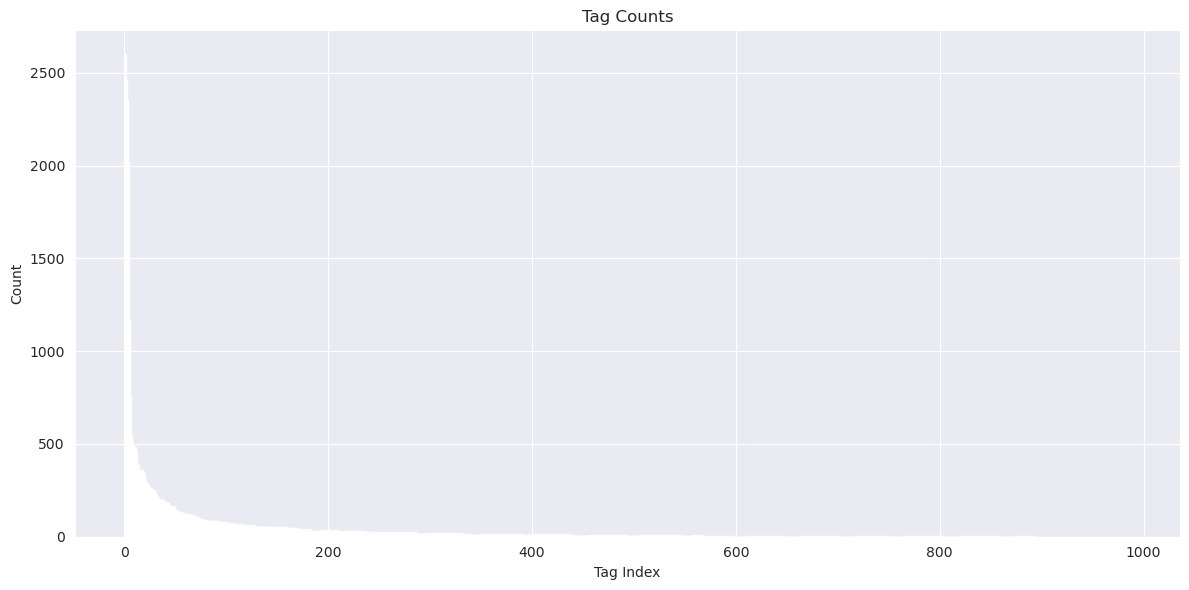

In [15]:
import matplotlib.pyplot as plt
import numpy as np

plot_y = np.array(df_tag_counts['Count'])
num_elements = len(plot_y)
plot_x = np.arange(1, num_elements + 1)  

plt.figure(figsize=(12, 6))  
plt.bar(plot_x, plot_y)

plt.xlabel('Tag Index')
plt.ylabel('Count')
plt.title('Tag Counts')

plt.tight_layout()
plt.show()

Next, we can enrich the df_tag_counts with a cumulative frequency column that counts how much percent that tag and the ones above (the more frequent ones) account for in the total number of tags.

In [16]:
total = df_tag_counts['Count'].sum()
df_tag_counts['cumulative_freq'] = (df_tag_counts['Count'].cumsum() / total * 100).round(2)

display(df_tag_counts.head(10))

,Tag,Count,cumulative_freq
0,neural-networks,2600,6.27
1,reinforcement-learning,2462,12.21
2,machine-learning,2354,17.89
3,deep-learning,2021,22.77
4,convolutional-neural-networks,1179,25.61
5,natural-language-processing,759,27.44
6,computer-vision,536,28.74
7,deep-rl,510,29.97
8,training,489,31.15
9,classification,484,32.31


We can see that the top 10 tags actually account for a third of all tags that have ever been used. Let's see how many questions out of all the 12380 contain at least one of these top 10 tags.

In [17]:
NUM_TAGS_STOP = 10

top_ten_tags = set(df_tag_counts['Tag'].head(NUM_TAGS_STOP).to_numpy())
count = 0
for instance in df_raw['Tags']:
    if set(instance) & top_ten_tags:
        count+=1

print(f"Vkupno {count} postovi sodrzat barem eden od top {NUM_TAGS_STOP} tagovite :)")

Vkupno 8981 postovi sodrzat barem eden od top 10 tagovite :)


We can see that out of 12300 posts, 8981 contain at least one of the top 10 tags. We can plot NUM_POSTS_COVERED against NUM_TAGS_USED to see when it stops growing, sort of like the elbow method but used in a different context here.

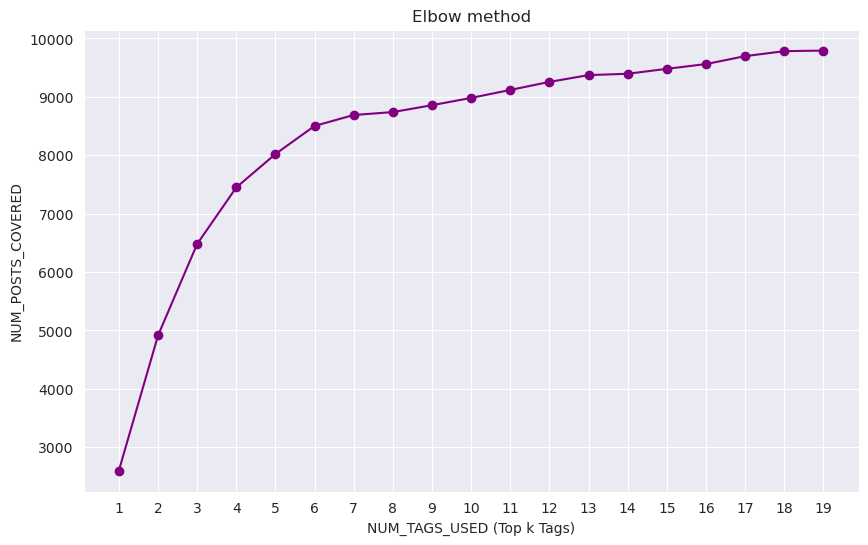

In [18]:
import matplotlib.pyplot as plt

tag_list = df_tag_counts['Tag'].to_numpy()
x_vals = []
y_vals = []

for k in range(1, 20):
    current_top_tags = set(tag_list[:k])
    count = sum(bool(set(tags) & current_top_tags) for tags in df_raw['Tags'])
    x_vals.append(k)
    y_vals.append(count)

plt.figure(figsize=(10,6))
plt.plot(x_vals, y_vals, marker='o', color='purple')
plt.title('Elbow method')
plt.xlabel('NUM_TAGS_USED (Top k Tags)')
plt.ylabel('NUM_POSTS_COVERED')
plt.grid(True)
plt.xticks(range(1,20))
plt.show()


Seeing as there is no clear elbow, we turn to a more non-visual approach. We are going to visualize the ratio of the [posts_covered/tags_used]

In [19]:
for x,y in zip(x_vals,y_vals):
    print(f"Ratio for {x} tags: {y/x} [posts_covered/tags_used]")

Ratio for 1 tags: 2600.0 [posts_covered/tags_used]
Ratio for 2 tags: 2456.5 [posts_covered/tags_used]
Ratio for 3 tags: 2160.0 [posts_covered/tags_used]
Ratio for 4 tags: 1862.0 [posts_covered/tags_used]
Ratio for 5 tags: 1604.0 [posts_covered/tags_used]
Ratio for 6 tags: 1416.8333333333333 [posts_covered/tags_used]
Ratio for 7 tags: 1241.142857142857 [posts_covered/tags_used]
Ratio for 8 tags: 1092.25 [posts_covered/tags_used]
Ratio for 9 tags: 984.0 [posts_covered/tags_used]
Ratio for 10 tags: 898.1 [posts_covered/tags_used]
Ratio for 11 tags: 828.8181818181819 [posts_covered/tags_used]
Ratio for 12 tags: 771.25 [posts_covered/tags_used]
Ratio for 13 tags: 720.8461538461538 [posts_covered/tags_used]
Ratio for 14 tags: 671.0 [posts_covered/tags_used]
Ratio for 15 tags: 631.9333333333333 [posts_covered/tags_used]
Ratio for 16 tags: 597.5 [posts_covered/tags_used]
Ratio for 17 tags: 570.3529411764706 [posts_covered/tags_used]
Ratio for 18 tags: 543.3888888888889 [posts_covered/tags_used

We notice that from 8-13 tags, the growth is slow and linear. We don't cover much new ground with each tag added yet we exponentially increase the label space which is going to be hard. So we make the cut-off at _ labels.

In [20]:
NUM_TAGS = 10
top_k_tags = set(tag_list[:NUM_TAGS])

df_raw['Tags'] = df_raw['Tags'].apply(lambda tags: list(set(tags) & top_k_tags))

df_raw = df_raw[df_raw['Tags'].apply(lambda x: len(x) > 0)].reset_index(drop=True)

In [21]:
df_raw.head(10)

,OwnerUserId,Content,Tags
0,8,"What is ""backprop""? What does ""backprop"" mean?...",[neural-networks]
1,8,How does noise affect generalization? Does inc...,"[machine-learning, neural-networks]"
2,8,How to find the optimal number of neurons per ...,[neural-networks]
3,38,Can a single neural network handle recognizing...,[neural-networks]
4,8,"What is ""early stopping"" in machine learning? ...",[deep-learning]
5,69,What is the difference between artificial inte...,[machine-learning]
6,8,What is the purpose of the hidden layers? Why ...,"[deep-learning, neural-networks]"
7,8,How can the generalization error be estimated?...,[machine-learning]
8,62,Is it possible to implement reinforcement lear...,"[deep-rl, neural-networks, reinforcement-learn..."
9,77,What are the main problems hindering current A...,[machine-learning]


In [22]:
df_raw.shape

(8981, 3)

### ADDITIONAL CLEANING, TOKENIZING AND LEMMATIZING

We also notice regexes in the content, even though the html tags are removed, things like \n \t still remain.

In [23]:
import re

def clean_text(text):
    text = text.lower()  # da se napravi lowercase
    text = re.sub(r'\n|\t', ' ', text) #otstranuvame \n i \t
    text = re.sub(r'[^a-zA-Z0-9 ]', '', text)  # otstranuvame interpunkciski znaci
    text = re.sub(r'\s+', ' ', text)  # otstranuvame posledovatelni spaces
    return text.strip() #pocetni i krajni empty spaces

df_raw['Content'] = df_raw['Content'].apply(clean_text)

Next, we can move onto the classical preprocessing of the data. Between stemming or lemmatization, we will choose lemmatization. This is because we want to preserve the semantic meaning of the words.

In [24]:
import spacy
nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    # nlp e gotova f-ja koja
    doc = nlp(text)
    # ekstrahiraj
    processed_tokens = []
    for token in doc:
        if not token.is_stop and token.is_alpha: #ako ne e stopword i e so bukvi
            processed_tokens.append(token.lemma_)
    # spoj gi tokenite vo edinstven string za ponatamu tekstot da se vektorizira
    return ' '.join(processed_tokens)

# na Content kolonata ja primenuvame preprocess procedurata
df_raw['LemmatizedContent'] = df_raw['Content'].apply(preprocess_text)

# kreirame i corpus za ponatamosna analiza.
corpus = df_raw['LemmatizedContent']

In [25]:
corpus

0       backprop backprop mean backprop term basically...
1       noise affect generalization increase noise dat...
2       find optimal number neuron layer write algorit...
3       single neural network handle recognize type ob...
4       early stop machine learn early stop machine le...
                              ...                        
8976    bellman backup unbiased come opinion hatq unbi...
8977    object detection model visualization netron tr...
8978    problem understand instruction finetune m try ...
8979    clarification model pretraine objective denois...
8980    influence unused ffn model accuracy pytorch en...
Name: LemmatizedContent, Length: 8981, dtype: object

Before we move onto vectorizing our data, let's explore the size of the corpus and some other descriptive features.

CORPUS DESCRIPTIVE STATISTICS

1. SOME BASICS
------------------------------
Total posts: 8,981
Total words (after preprocessing): 684,383
Unique words: 38,172
Average words per post: 76.20

2. POST LENGTH ANALYSIS
------------------------------
Min post word count: 6
Max post word count: 1519
Median post word count: 59.0
Standard deviation of word counts in posts: 69.99


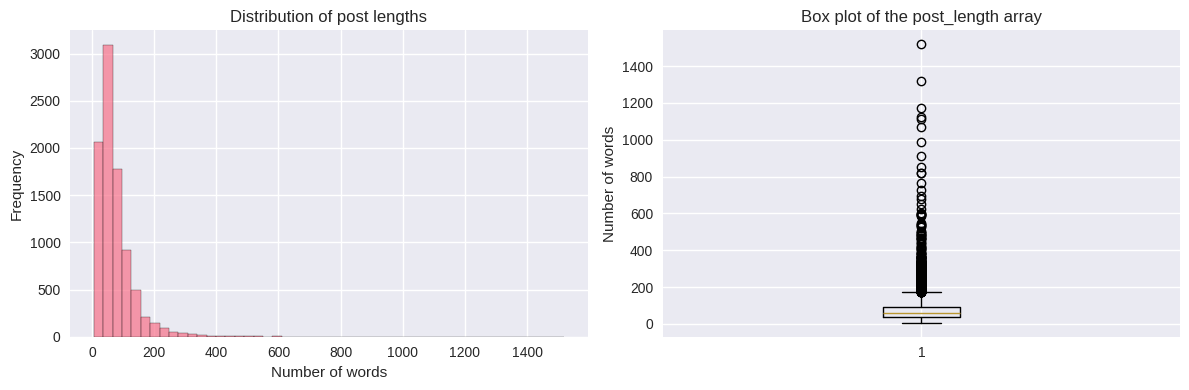


3. MOST COMMON WORDS
------------------------------
Top 20 most frequent words:
network           8038 (1.17%)
model             7311 (1.07%)
neural            5092 (0.74%)
image             5014 (0.73%)
function          4459 (0.65%)
datum             4446 (0.65%)
input             4335 (0.63%)
use               4263 (0.62%)
value             4242 (0.62%)
layer             4219 (0.62%)
not               4138 (0.60%)
train             4106 (0.60%)
learning          4068 (0.59%)
action            4064 (0.59%)
state             4045 (0.59%)
learn             3981 (0.58%)
output            3944 (0.58%)
m                 3761 (0.55%)
like              3746 (0.55%)
problem           3724 (0.54%)


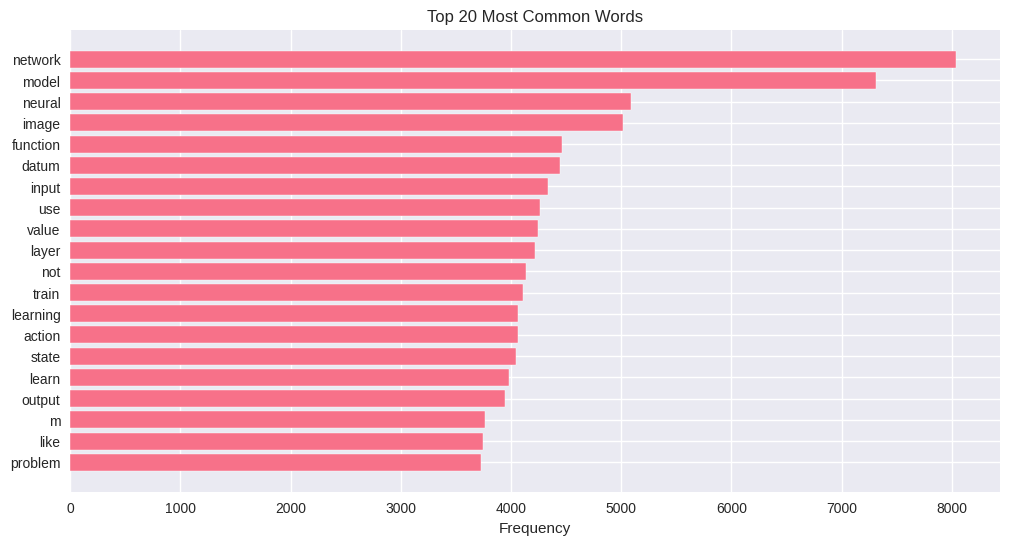


4. WORD FREQUENCY DISTRIBUTION
------------------------------


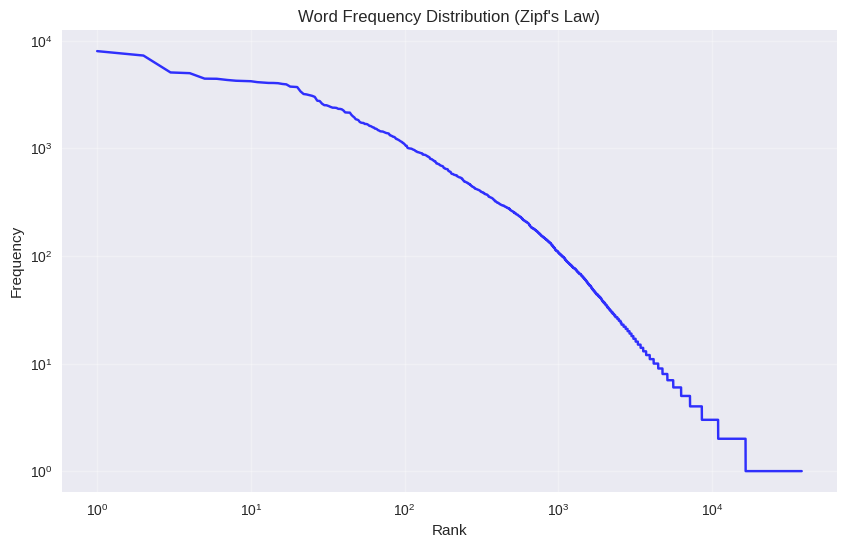


5. VOCABULARY RICHNESS
------------------------------
Type-Token Ratio (TTR): 0.0558
Words appearing only once: 21,711
Percentage of words that appear only once: 56.88%

6. TAG ANALYSIS
Average tags per post: 1.49

7. WORD CLOUD
------------------------------


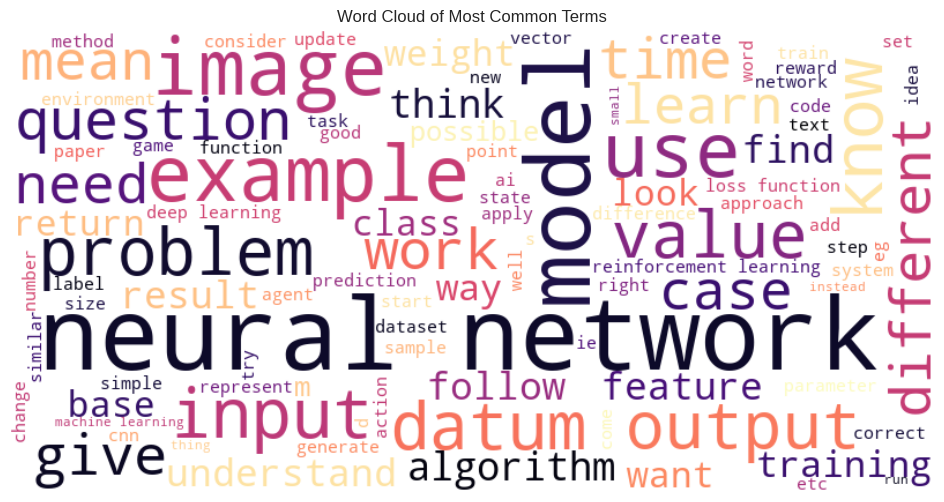

In [26]:
import seaborn as sns
from wordcloud import WordCloud
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("CORPUS DESCRIPTIVE STATISTICS")
print("="*45)

# 1. Basic corpus statistics
print("\n1. SOME BASICS")
print("-"*30)
total_posts = len(df_raw)
all_words = []
for sublist in df_raw['LemmatizedContent'].str.split():
    for word in sublist:
        all_words.append(word)
total_words = len(all_words)
unique_words = len(set(all_words))

print(f"Total posts: {total_posts:,}")
print(f"Total words (after preprocessing): {total_words:,}")
print(f"Unique words: {unique_words:,}")
print(f"Average words per post: {total_words/total_posts:.2f}")

print("\n2. POST LENGTH ANALYSIS")
print("-"*30)
doc_lengths = df_raw['LemmatizedContent'].str.split().str.len()
print(f"Min post word count: {doc_lengths.min()}")
print(f"Max post word count: {doc_lengths.max()}")
print(f"Median post word count: {doc_lengths.median():.1f}")
print(f"Standard deviation of word counts in posts: {doc_lengths.std():.2f}")

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(doc_lengths, bins=50, alpha=0.7, edgecolor='black')
plt.title('Distribution of post lengths')
plt.xlabel('Number of words')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.boxplot(doc_lengths)
plt.title('Box plot of the post_length array')
plt.ylabel('Number of words')

plt.tight_layout()
plt.show()

print("\n3. MOST COMMON WORDS")
print("-" * 30)
word_freq = Counter(all_words)
most_common = word_freq.most_common(20)

print("Top 20 most frequent words:")
for word, count in most_common:
    print(f"{word:<15} {count:>6} ({count/len(all_words)*100:.2f}%)")

# Word frequency
words, counts = zip(*most_common)
plt.figure(figsize=(12, 6))
plt.barh(range(len(words)), counts)
plt.yticks(range(len(words)), words)
plt.xlabel('Frequency')
plt.title('Top 20 Most Common Words')
plt.gca().invert_yaxis()
plt.show()

# 4. Distribution of the frequency of the words (Zipf's law)
print("\n4. WORD FREQUENCY DISTRIBUTION")
print("-" * 30)
sorted_freqs = sorted(word_freq.values(), reverse=True)
ranks = range(1, len(sorted_freqs) + 1)

plt.figure(figsize=(10, 6))
plt.loglog(ranks, sorted_freqs, 'b-', alpha=0.8)
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.title("Word Frequency Distribution (Zipf's Law)")
plt.grid(True, alpha=0.3)
plt.show()

# 5. Vocabulary analysis
print("\n5. VOCABULARY RICHNESS")
print("-" * 30)
vocabulary_richness = unique_words / total_words
print(f"Type-Token Ratio (TTR): {vocabulary_richness:.4f}")
hapax_count = list(word_freq.values()).count(1)
print(f"Words appearing only once: {hapax_count:,}")
print(f"Percentage of words that appear only once: {hapax_count/unique_words*100:.2f}%")

# 6. Tag analysis
print("\n6. TAG ANALYSIS")
avg_tags_per_post = df_raw['Tags'].apply(len).mean()
print(f"Average tags per post: {avg_tags_per_post:.2f}")

# 7. Word cloud
print("\n7. WORD CLOUD")
print("-" * 30)
wordcloud = WordCloud(width=800, height=400,colormap='magma',max_words=100,background_color='white').generate(' '.join(all_words))
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Common Terms')
plt.show()

### VECTORIZING

Next, we should get the BoW representation. From our visualization we see that only the top 100 words appear >1000 times. But let's also plot the document frequency of the most frequent words (including bigrams which can be important e.g. reinforcement learning; neural network etc.)

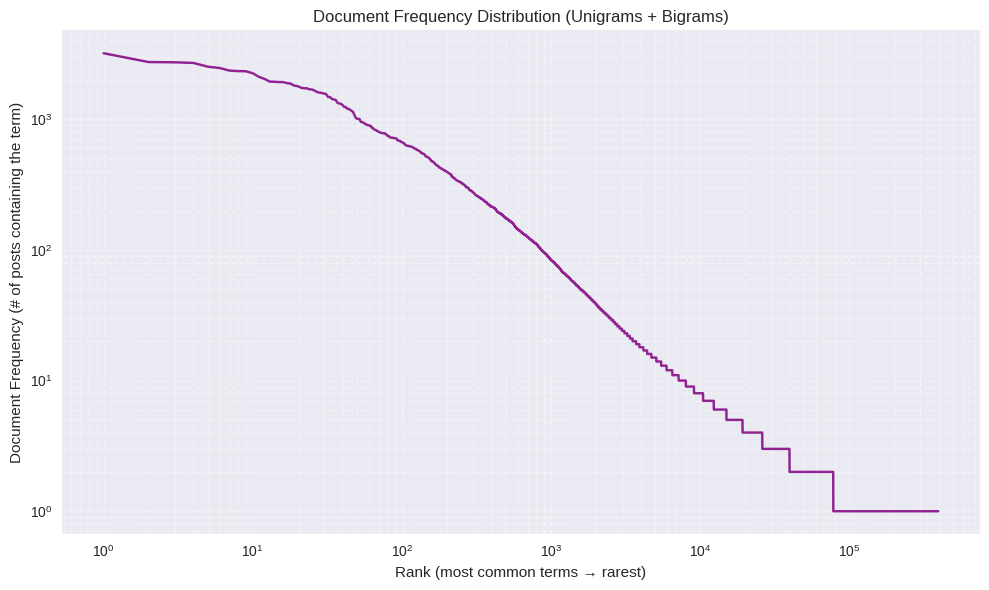

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

# unigrams i bigrams koristime
vectorizer = CountVectorizer(ngram_range=(1, 2))
X = vectorizer.fit_transform(corpus)

doc_freqs = (X > 0).sum(axis=0).A1  # flattening na matricata
sorted_doc_freqs = np.sort(doc_freqs)[::-1]
ranks = range(1, len(sorted_doc_freqs) + 1)

plt.figure(figsize=(10, 6))
plt.loglog(ranks, sorted_doc_freqs, color='purple', alpha=0.85)
plt.xlabel('Rank (most common terms → rarest)')
plt.ylabel('Document Frequency (# of posts containing the term)')
plt.title('Document Frequency Distribution (Unigrams + Bigrams)')
plt.grid(True, which="both", linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

We notice that max_features=2000 is a reasonable cut-off because every word/bigram past the 2000th appears in <30 of the posts, which is not enough.

We will create the BoW representation first.

In [28]:
#1 BoW vectorizer
print("Creating BoW DataFrame...")
bow_vectorizer = CountVectorizer(max_features=2000, ngram_range=(1, 2))
bow_features = bow_vectorizer.fit_transform(corpus)

# BoW df
df_bow = pd.DataFrame(
    bow_features.toarray(),
    columns=bow_vectorizer.get_feature_names_out()
)

# Kolonite UserId i Tags gi dodavame sekako
df_bow['UserId'] = df_raw['OwnerUserId'].values
df_bow['Tags'] = df_raw['Tags'].values
print(f"BoW DataFrame shape: {df_bow.shape}")
display(df_bow)

Creating BoW DataFrame...
BoW DataFrame shape: (8981, 2002)


,ability,able,able find,absolute,abstract,acc,acc valloss,accept,access,accomplish,...,yi,yield,yolo,youtube,ypred,yt,ytrain,zero,UserId,Tags
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,8,[neural-networks]
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,8,"[machine-learning, neural-networks]"
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,8,[neural-networks]
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,38,[neural-networks]
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,8,[deep-learning]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8976,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,81939,[reinforcement-learning]
8977,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,82079,[deep-learning]
8978,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,64349,[natural-language-processing]
8979,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,79283,[natural-language-processing]


Next, we will create the TF-IDF representation.

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 2. TF-IDF vectorizer
print("Creating TF-IDF DataFrame...")
tfidf_vectorizer = TfidfVectorizer(max_features=2000, ngram_range=(1, 2))
tfidf_features = tfidf_vectorizer.fit_transform(corpus)

# TF-IDF df
df_tfidf = pd.DataFrame(
    tfidf_features.toarray(),
    columns=tfidf_vectorizer.get_feature_names_out()
)

# UserId i Tags
df_tfidf['UserId'] = df_raw['OwnerUserId'].values
df_tfidf['Tags'] = df_raw['Tags'].values

print(f"TF-IDF DataFrame shape: {df_tfidf.shape}")
display(df_tfidf)

Creating TF-IDF DataFrame...
TF-IDF DataFrame shape: (8981, 2002)


,ability,able,able find,absolute,abstract,acc,acc valloss,accept,access,accomplish,...,yi,yield,yolo,youtube,ypred,yt,ytrain,zero,UserId,Tags
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,[neural-networks]
1,0.226115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,"[machine-learning, neural-networks]"
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,[neural-networks]
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38,[neural-networks]
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,[deep-learning]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8976,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81939,[reinforcement-learning]
8977,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,82079,[deep-learning]
8978,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64349,[natural-language-processing]
8979,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,79283,[natural-language-processing]


In [30]:
bow_cols = set(df_bow.columns)
tfidf_cols = set(df_tfidf.columns)

differing_cols = bow_cols.symmetric_difference(tfidf_cols)

print(f"Number of differing columns: {len(differing_cols)}")

Number of differing columns: 0


In [31]:
from sklearn.decomposition import TruncatedSVD

max_components = min(tfidf_features.shape) - 1
svd_full = TruncatedSVD(n_components=max_components, random_state=42)
svd_full.fit(tfidf_features)
cumulative_variance = svd_full.explained_variance_ratio_.cumsum() # kumulativno do n-tata najznacajna komponenta se do 1, pr. ova moze da lici 0.7 0.87 0.95 0.98 1
target_variance = 0.9
NUM_COMPS = np.argmax(cumulative_variance >= target_variance) + 1
print(f"Components for {target_variance*100}% explained variance variance: {NUM_COMPS}")

# Fituvanje na soodvetniot broj na komponenti
svd = TruncatedSVD(n_components=NUM_COMPS, random_state=42)
svd_features = svd.fit_transform(tfidf_features)

# SVD DF
df_svd = pd.DataFrame(
    svd_features,
    columns=[f'SVD_F{i}' for i in range(svd_features.shape[1])]
)
# gi vrakjame
df_svd['UserId'] = df_raw['OwnerUserId'].values
df_svd['Tags'] = df_raw['Tags'].values
print(f"SVD DataFrame shape: {df_svd.shape}")

# Print detailed variance analysis
print(f"Actual variance preserved: {svd.explained_variance_ratio_.sum():.3f}")
print(f"Dimensionality reduction: {tfidf_features.shape[1]} → {NUM_COMPS}")
print(f"Compression ratio: {NUM_COMPS/tfidf_features.shape[1]:.3f}")

Components for 90.0% explained variance variance: 1156
SVD DataFrame shape: (8981, 1158)
Actual variance preserved: 0.899
Dimensionality reduction: 2000 → 1156
Compression ratio: 0.578


In [32]:
df_svd

,SVD_F0,SVD_F1,SVD_F2,SVD_F3,SVD_F4,SVD_F5,SVD_F6,SVD_F7,SVD_F8,SVD_F9,...,SVD_F1148,SVD_F1149,SVD_F1150,SVD_F1151,SVD_F1152,SVD_F1153,SVD_F1154,SVD_F1155,UserId,Tags
0,0.038217,0.002815,-0.006990,0.004353,-0.010260,0.002652,0.021197,-0.008280,-0.006323,-0.016725,...,-0.006912,-0.026905,0.024435,0.005727,-0.013404,0.011363,-0.011282,-0.036086,8,[neural-networks]
1,0.112166,-0.013042,0.006837,-0.043799,-0.028056,-0.011379,-0.006225,0.012878,-0.030559,-0.011088,...,0.007520,-0.017852,-0.007378,-0.009985,0.006395,0.004176,-0.001409,0.009635,8,"[machine-learning, neural-networks]"
2,0.155763,-0.023388,-0.074388,0.110855,-0.011769,0.178411,0.038641,0.021356,-0.047644,-0.070493,...,0.011560,-0.032231,0.002482,0.012328,0.003176,0.023005,0.009305,0.009200,8,[neural-networks]
3,0.202467,-0.084304,-0.035768,-0.078389,0.049476,-0.012242,-0.033541,-0.037254,0.031415,-0.014400,...,0.009994,-0.013497,0.011767,-0.009479,0.023740,-0.003737,0.004824,-0.005624,38,[neural-networks]
4,0.102594,0.016948,0.041145,-0.166999,-0.100130,0.083704,0.124772,0.055128,-0.031861,0.002958,...,-0.006912,-0.007403,0.009296,0.003851,-0.017630,-0.023686,-0.004295,0.010568,8,[deep-learning]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8976,0.039457,0.044767,-0.010442,0.022035,-0.005730,-0.030758,0.057263,-0.035759,-0.015786,-0.037691,...,0.001204,0.020949,-0.012213,-0.000946,0.004478,0.028090,0.010427,0.007021,81939,[reinforcement-learning]
8977,0.212414,-0.101847,0.097701,0.133008,-0.001643,0.044194,-0.080623,-0.047377,0.042149,0.111832,...,0.007135,0.000651,-0.011877,0.012352,0.016648,-0.003794,0.008192,-0.005291,82079,[deep-learning]
8978,0.165186,-0.032008,0.078081,0.041588,-0.077051,0.016986,-0.044068,-0.073456,0.017827,0.034503,...,0.020428,-0.007299,-0.038915,-0.001754,0.031453,0.006244,-0.029547,-0.004025,64349,[natural-language-processing]
8979,0.202443,-0.033894,0.101266,0.064942,-0.114449,0.075415,-0.050542,-0.157199,0.048614,0.072094,...,0.006038,-0.010788,-0.003105,-0.001330,0.004720,-0.004767,-0.004224,0.018869,79283,[natural-language-processing]


### SCALING

For the BoW dataframe, we will use standard scaling, whereas for the SVD we will use robust scaling. TF-IDF we consider to be scaled already. This is because we want to preserve the outliers in the TF-IDF and SVD because of the usually skewed distributions. Finally, we will separate the feature columns and the target column.

In [33]:
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler
mmscaler = MinMaxScaler()

# Standard scaling for BoW
scaler_bow = StandardScaler()
X_bow_scaled = mmscaler.fit_transform(scaler_bow.fit_transform(df_bow.drop(columns=['UserId', 'Tags'])))
X_bow = pd.DataFrame(X_bow_scaled, columns=df_bow.drop(columns=['UserId', 'Tags']).columns)
X_bow['UserId'] = df_bow['UserId'].values

# tf-idf - we won't scale
X_tfidf = df_tfidf.drop(columns=['Tags'])

# Robust scaling for SVD df
scaler_svd = RobustScaler()
X_svd_scaled = mmscaler.fit_transform(scaler_svd.fit_transform(df_svd.drop(columns=['UserId', 'Tags'])))
X_svd = pd.DataFrame(X_svd_scaled, columns=df_svd.drop(columns=['UserId', 'Tags']).columns)
X_svd['UserId'] = df_svd['UserId'].values

y = df_raw['Tags']

# 2. TRAINING THE MODELS

In this section, we will train 3 models: Naive Bayes, Random Forest, XGBoost.

For the hamming loss, we can calculate a base dummy classifier hamming loss to compare to.

In [34]:
df_tag_counts['cum_sum'] = df_tag_counts['Count'].cumsum()

NUM_TAGS = 10
total_preds = df_raw.shape[0] * NUM_TAGS # rows * tags_per_row

positives = df_tag_counts.iloc[NUM_TAGS-1,df_tag_counts.columns.get_loc('cum_sum')]

base_loss = positives/total_preds

print(f"Base Hamming loss: {base_loss}")

Base Hamming loss: 0.14913706714174368


In [64]:
df_tag_counts.iloc[:10,0].to_numpy()

array(['neural-networks', 'reinforcement-learning', 'machine-learning',
       'deep-learning', 'convolutional-neural-networks',
       'natural-language-processing', 'computer-vision', 'deep-rl',
       'training', 'classification'], dtype=object)

In [65]:
label_names = ['neural-networks', 'reinforcement-learning', 'machine-learning','deep-learning', 'convolutional-neural-networks','natural-language-processing','computer-vision','deep-rl','training', 'classification']

## 2.1. Using SKLEARN's Multilabel Binarizer (binary relevance method)

Binary Relevance trains one independent binary classifier per label. It assumes that all labels are independent, which simplifies training but may miss inter-label relationships. We use MultiLabelBinarizer to transform tags and fit classifiers directly.

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import (f1_score, recall_score, precision_score, hamming_loss, accuracy_score)
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(y)

from sklearn.metrics import multilabel_confusion_matrix

def train_eval(X, Y, model, test_size=0.2, label_names=label_names):
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=test_size, random_state=42, stratify=None
    )
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)

    metrics = {
        'f1_macro': f1_score(Y_test, Y_pred, average='macro', zero_division=0),
        'f1_micro': f1_score(Y_test, Y_pred, average='micro', zero_division=0),
        'avg_recall': recall_score(Y_test, Y_pred, average='macro', zero_division=0),
        'avg_precision': precision_score(Y_test, Y_pred, average='macro', zero_division=0),
        'hamming_loss': hamming_loss(Y_test, Y_pred),
        'subset_accuracy': accuracy_score(Y_test, Y_pred)
    }

    confusion_matrices = multilabel_confusion_matrix(Y_test, Y_pred)

    for i, cm in enumerate(confusion_matrices):
        tn, fp, fn, tp = cm.ravel()
        print(f"\nLabel: {label_names[i]}")
        print(f"[[TN: {tn}, FP: {fp}] [FN: {fn}, TP: {tp}]]")

    return metrics


In [71]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.multiclass import OneVsRestClassifier

results = {}

# 1. NAIVE BAYES
print("=" * 50)
print("NAIVE BAYES EVALUATION")
print("=" * 50)

# Naive Bayes for BoW (MultinomialNB)
print("\n1. MultinomialNB on BoW features:")
nb_bow = OneVsRestClassifier(MultinomialNB())
metrics_nb_bow = train_eval(X_bow.drop(columns=['UserId']), Y, nb_bow)
results['NB_BoW'] = metrics_nb_bow
print()
for metric, value in metrics_nb_bow.items():
    print(f"  {metric}: {value:.4f}")
print()
print("-" * 50)
print()

# Naive Bayes for TF-IDF (MultinomialNB)
print("\n2. MultinomialNB on TF-IDF features:")
nb_tfidf = OneVsRestClassifier(MultinomialNB())
metrics_nb_tfidf = train_eval(X_tfidf.drop(columns=['UserId']), Y, nb_tfidf)
results['NB_TFIDF'] = metrics_nb_tfidf
print()
for metric, value in metrics_nb_tfidf.items():
    print(f"  {metric}: {value:.4f}")
print()
print("-" * 50)
print()
# Naive Bayes for SVD (GaussianNB)
print("\n3. GaussianNB on SVD features:")
nb_svd = OneVsRestClassifier(GaussianNB())
metrics_nb_svd = train_eval(X_svd.drop(columns=['UserId']), Y, nb_svd)
results['NB_SVD'] = metrics_nb_svd
print()
for metric, value in metrics_nb_svd.items():
    print(f"  {metric}: {value:.4f}")
print()
print("-" * 50)
print()

NAIVE BAYES EVALUATION

1. MultinomialNB on BoW features:

Label: neural-networks
[[TN: 1671, FP: 14] [FN: 102, TP: 10]]

Label: reinforcement-learning
[[TN: 1668, FP: 25] [FN: 82, TP: 22]]

Label: machine-learning
[[TN: 1493, FP: 58] [FN: 121, TP: 125]]

Label: deep-learning
[[TN: 1289, FP: 106] [FN: 317, TP: 85]]

Label: convolutional-neural-networks
[[TN: 1657, FP: 33] [FN: 91, TP: 16]]

Label: natural-language-processing
[[TN: 1198, FP: 122] [FN: 315, TP: 162]]

Label: computer-vision
[[TN: 1627, FP: 29] [FN: 87, TP: 54]]

Label: deep-rl
[[TN: 1168, FP: 111] [FN: 260, TP: 258]]

Label: training
[[TN: 1295, FP: 26] [FN: 53, TP: 423]]

Label: classification
[[TN: 1682, FP: 9] [FN: 103, TP: 3]]

  f1_macro: 0.3968
  f1_micro: 0.5288
  avg_recall: 0.3308
  avg_precision: 0.5452
  hamming_loss: 0.1149
  subset_accuracy: 0.2955

--------------------------------------------------


2. MultinomialNB on TF-IDF features:

Label: neural-networks
[[TN: 1684, FP: 1] [FN: 110, TP: 2]]

Label: re

We can see that the BoW and TF-IDF datasets have a hamming loss less than the base loss we calculated so the model learned something at least. We will focus on the micro-f1 score bc it prioritizes the more frequent tags. SVD performs really poorly but that could also just be because of the choice of a Gaussian classifier.

The low recall suggests a lot of false negatives - which means that the model wrongly predicts that labels are NOT present when they are. This can be dealt with if we oversample for example.

In [72]:
from sklearn.ensemble import RandomForestClassifier

# 2. RANDOM FOREST
print("\n" + "=" * 50)
print("RANDOM FOREST EVALUATION")
print("=" * 50)

# Random Forest for BoW
print("\n1. Random Forest on BoW features:")
rf_bow = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
metrics_rf_bow = train_eval(X_bow.drop(columns=['UserId']), Y, rf_bow)
results['RF_BoW'] = metrics_rf_bow
print()
for metric, value in metrics_rf_bow.items():
    print(f"  {metric}: {value:.4f}")
print()
print("-"*50)
print()
# Random Forest for TF-IDF
print("\n2. Random Forest on TF-IDF features:")
rf_tfidf = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
metrics_rf_tfidf = train_eval(X_tfidf.drop(columns=['UserId']), Y, rf_tfidf)
results['RF_TFIDF'] = metrics_rf_tfidf
print()
for metric, value in metrics_rf_tfidf.items():
    print(f"  {metric}: {value:.4f}")
print()
print("-"*50)
print()
# Random Forest for SVD
print("\n3. Random Forest on SVD features:")
rf_svd = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
metrics_rf_svd = train_eval(X_svd.drop(columns=['UserId']), Y, rf_svd)
results['RF_SVD'] = metrics_rf_svd
print()
for metric, value in metrics_rf_svd.items():
    print(f"  {metric}: {value:.4f}")
print()
print("-"*50)
print()


RANDOM FOREST EVALUATION

1. Random Forest on BoW features:

Label: neural-networks
[[TN: 1684, FP: 1] [FN: 111, TP: 1]]

Label: reinforcement-learning
[[TN: 1685, FP: 8] [FN: 92, TP: 12]]

Label: machine-learning
[[TN: 1514, FP: 37] [FN: 91, TP: 155]]

Label: deep-learning
[[TN: 1361, FP: 34] [FN: 320, TP: 82]]

Label: convolutional-neural-networks
[[TN: 1688, FP: 2] [FN: 103, TP: 4]]

Label: natural-language-processing
[[TN: 1278, FP: 42] [FN: 339, TP: 138]]

Label: computer-vision
[[TN: 1632, FP: 24] [FN: 63, TP: 78]]

Label: deep-rl
[[TN: 1173, FP: 106] [FN: 187, TP: 331]]

Label: training
[[TN: 1293, FP: 28] [FN: 33, TP: 443]]

Label: classification
[[TN: 1691, FP: 0] [FN: 105, TP: 1]]

  f1_macro: 0.4016
  f1_micro: 0.5906
  avg_recall: 0.3417
  avg_precision: 0.7510
  hamming_loss: 0.0960
  subset_accuracy: 0.3756

--------------------------------------------------


2. Random Forest on TF-IDF features:

Label: neural-networks
[[TN: 1685, FP: 0] [FN: 110, TP: 2]]

Label: reinfo

Looking at the confusion matrices, we can tell the model handles some tags pretty well — for example, 'training' stands out as one it gets right most of the time. On the other hand, tags like 'neural-networks' and 'classification' don’t perform nearly as well. This might be because they’re broader and harder to pin down. Since we're using basic vectorization methods, the model might be missing the deeper context or meaning behind those tags. More advanced techniques like word embeddings or neural networks could help capture that kind of information better. Additionally, there are a lot of filler words that seemingly don't contribute and could even confuse the models, so feature selection should be considered.

In [40]:
# 3. K-NEAREST NEIGHBORS with COSINE SIMILARITY

print("\n" + "=" * 50)
print("K-NEAREST NEIGHBORS (KNN) with COSINE SIMILARITY EVALUATION")
print("=" * 50)

from sklearn.neighbors import KNeighborsClassifier

# KNN for BoW
print("\n1. KNN on BoW features:")
knn_bow = OneVsRestClassifier(KNeighborsClassifier(
    n_neighbors=5, metric='cosine', algorithm='brute', n_jobs=-1))
metrics_knn_bow = train_eval(X_bow.drop(columns=['UserId']), Y, knn_bow)
results['KNN_COSINE_BoW'] = metrics_knn_bow
for metric, value in metrics_knn_bow.items():
    print(f"  {metric}: {value:.4f}")

# KNN for TF-IDF
print("\n2. KNN on TF-IDF features:")
knn_tfidf = OneVsRestClassifier(KNeighborsClassifier(
    n_neighbors=5, metric='cosine', algorithm='brute', n_jobs=-1))
metrics_knn_tfidf = train_eval(X_tfidf.drop(columns=['UserId']), Y, knn_tfidf)
results['KNN_COSINE_TFIDF'] = metrics_knn_tfidf
for metric, value in metrics_knn_tfidf.items():
    print(f"  {metric}: {value:.4f}")


# KNN for SVD
print("\n3. KNN on SVD features:")
knn_svd = OneVsRestClassifier(KNeighborsClassifier(
    n_neighbors=5, metric='cosine', algorithm='brute', n_jobs=-1))
metrics_knn_svd = train_eval(X_svd.drop(columns=['UserId']), Y, knn_svd)
results['KNN_COSINE_SVD'] = metrics_knn_svd
for metric, value in metrics_knn_svd.items():
    print(f"  {metric}: {value:.4f}")


K-NEAREST NEIGHBORS (KNN) with COSINE SIMILARITY EVALUATION

1. KNN on BoW features:
  f1_macro: 0.2776
  f1_micro: 0.3936
  avg_recall: 0.2130
  avg_precision: 0.4960
  hamming_loss: 0.1391
  subset_accuracy: 0.2176

2. KNN on TF-IDF features:
  f1_macro: 0.3878
  f1_micro: 0.5008
  avg_recall: 0.3283
  avg_precision: 0.5432
  hamming_loss: 0.1243
  subset_accuracy: 0.3116

3. KNN on SVD features:
  f1_macro: 0.1957
  f1_micro: 0.3217
  avg_recall: 0.1709
  avg_precision: 0.4149
  hamming_loss: 0.1544
  subset_accuracy: 0.2020


In [41]:
print("\n" + "=" * 50)
print("SUMMARY COMPARISON")
print("=" * 50)

results_df = pd.DataFrame(results).T
print("\nComplete Results Table:")
print(results_df.round(4))


SUMMARY COMPARISON

Complete Results Table:
                  f1_macro  f1_micro  avg_recall  avg_precision  hamming_loss  \
NB_BoW              0.3968    0.5288      0.3308         0.5452        0.1149   
NB_TFIDF            0.3326    0.5114      0.2721         0.5905        0.1087   
NB_SVD              0.4221    0.4626      0.5566         0.3521        0.2026   
RF_BoW              0.4016    0.5906      0.3417         0.7510        0.0960   
RF_TFIDF            0.3978    0.5866      0.3367         0.7224        0.0959   
RF_SVD              0.2002    0.3723      0.1499         0.5395        0.1176   
KNN_COSINE_BoW      0.2776    0.3936      0.2130         0.4960        0.1391   
KNN_COSINE_TFIDF    0.3878    0.5008      0.3283         0.5432        0.1243   
KNN_COSINE_SVD      0.1957    0.3217      0.1709         0.4149        0.1544   

                  subset_accuracy  
NB_BoW                     0.2955  
NB_TFIDF                   0.3200  
NB_SVD                     0.1124  


In the following subsections we will drop the SVD dataframe as it often performs worse than even the dummy multilabel classifier which would just predict 0's.
Not only does it perform worse, but the dimensionality reduction leads to loss of interpretability, so in addition to performing worse, it's also less interpretable.

## 2.2 MLB + univariate feature selection (chi2 criterion)

In [89]:
from sklearn.feature_selection import SelectKBest, chi2

def select_train_eval(X, Y, model, k=500, label_names=label_names, test_size=0.2):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
    X_train_sub, X_val, Y_train_sub, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=42)
    selector = SelectKBest(chi2, k=k)
    X_train_sub_sel = selector.fit_transform(X_train_sub, Y_train_sub)
    X_val_sel = selector.transform(X_val)
    X_test_sel = selector.transform(X_test)
    model.fit(np.vstack([X_train_sub_sel, X_val_sel]), np.vstack([Y_train_sub, Y_val]))
    Y_pred = model.predict(X_test_sel)
    metrics = {
        'f1_macro': f1_score(Y_test, Y_pred, average='macro', zero_division=0),
        'f1_micro': f1_score(Y_test, Y_pred, average='micro', zero_division=0),
        'avg_recall': recall_score(Y_test, Y_pred, average='macro', zero_division=0),
        'avg_precision': precision_score(Y_test, Y_pred, average='macro', zero_division=0),
        'hamming_loss': hamming_loss(Y_test, Y_pred),
        'subset_accuracy': accuracy_score(Y_test, Y_pred)
    }
    if label_names is not None:
        confusion_matrices = multilabel_confusion_matrix(Y_test, Y_pred)
        for i, cm in enumerate(confusion_matrices):
            tn, fp, fn, tp = cm.ravel()
            print(f"\nLabel: {label_names[i]}")
            print(f"[[TN: {tn}, FP: {fp}] [FN: {fn}, TP: {tp}]]")
    return metrics

In [90]:
results = {}

# 1. NAIVE BAYES
print("=" * 50)
print("NAIVE BAYES EVALUATION")
print("=" * 50)

# Naive Bayes for BoW (MultinomialNB)
print("\n1. MultinomialNB on BoW features:")
nb_bow = OneVsRestClassifier(MultinomialNB())
metrics_nb_bow = select_train_eval(X_bow.drop(columns=['UserId']), Y, nb_bow)
results['NB_BoW'] = metrics_nb_bow
print()
for metric, value in metrics_nb_bow.items():
    print(f"  {metric}: {value:.4f}")
print()
print("-" * 50)
print()

# Naive Bayes for TF-IDF (MultinomialNB)
print("\n2. MultinomialNB on TF-IDF features:")
nb_tfidf = OneVsRestClassifier(MultinomialNB())
metrics_nb_tfidf = select_train_eval(X_tfidf.drop(columns=['UserId']), Y, nb_tfidf)
results['NB_TFIDF'] = metrics_nb_tfidf
print()
for metric, value in metrics_nb_tfidf.items():
    print(f"  {metric}: {value:.4f}")
print()
print("-" * 50)
print()

# Naive Bayes for SVD (GaussianNB)
print("\n3. GaussianNB on SVD features:")
nb_svd = OneVsRestClassifier(GaussianNB())
metrics_nb_svd = select_train_eval(X_svd.drop(columns=['UserId']), Y, nb_svd)
results['NB_SVD'] = metrics_nb_svd
print()
for metric, value in metrics_nb_svd.items():
    print(f"  {metric}: {value:.4f}")
print()
print("-" * 50)
print()

NAIVE BAYES EVALUATION

1. MultinomialNB on BoW features:

Label: neural-networks
[[TN: 1678, FP: 7] [FN: 107, TP: 5]]

Label: reinforcement-learning
[[TN: 1671, FP: 22] [FN: 87, TP: 17]]

Label: machine-learning
[[TN: 1503, FP: 48] [FN: 129, TP: 117]]

Label: deep-learning
[[TN: 1341, FP: 54] [FN: 337, TP: 65]]

Label: convolutional-neural-networks
[[TN: 1664, FP: 26] [FN: 91, TP: 16]]

Label: natural-language-processing
[[TN: 1263, FP: 57] [FN: 381, TP: 96]]

Label: computer-vision
[[TN: 1638, FP: 18] [FN: 92, TP: 49]]

Label: deep-rl
[[TN: 1185, FP: 94] [FN: 290, TP: 228]]

Label: training
[[TN: 1298, FP: 23] [FN: 53, TP: 423]]

Label: classification
[[TN: 1690, FP: 1] [FN: 106, TP: 0]]

  f1_macro: 0.3588
  f1_micro: 0.5011
  avg_recall: 0.2873
  avg_precision: 0.5504
  hamming_loss: 0.1126
  subset_accuracy: 0.2844

--------------------------------------------------


2. MultinomialNB on TF-IDF features:

Label: neural-networks
[[TN: 1684, FP: 1] [FN: 112, TP: 0]]

Label: reinforc

In [91]:
# 2. RANDOM FOREST
print("\n" + "=" * 50)
print("RANDOM FOREST EVALUATION")
print("=" * 50)

# Random Forest for BoW
print("\n1. Random Forest on BoW features:")
rf_bow = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
metrics_rf_bow = select_train_eval(X_bow.drop(columns=['UserId']), Y, rf_bow)
results['RF_BoW'] = metrics_rf_bow
print()
for metric, value in metrics_rf_bow.items():
    print(f"  {metric}: {value:.4f}")
print()
print("-"*50)
print()
# Random Forest for TF-IDF
print("\n2. Random Forest on TF-IDF features:")
rf_tfidf = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
metrics_rf_tfidf = select_train_eval(X_tfidf.drop(columns=['UserId']), Y, rf_tfidf)
results['RF_TFIDF'] = metrics_rf_tfidf
print()
for metric, value in metrics_rf_tfidf.items():
    print(f"  {metric}: {value:.4f}")
print()
print("-"*50)
print()


RANDOM FOREST EVALUATION

1. Random Forest on BoW features:

Label: neural-networks
[[TN: 1676, FP: 9] [FN: 101, TP: 11]]

Label: reinforcement-learning
[[TN: 1679, FP: 14] [FN: 90, TP: 14]]

Label: machine-learning
[[TN: 1512, FP: 39] [FN: 81, TP: 165]]

Label: deep-learning
[[TN: 1350, FP: 45] [FN: 296, TP: 106]]

Label: convolutional-neural-networks
[[TN: 1684, FP: 6] [FN: 98, TP: 9]]

Label: natural-language-processing
[[TN: 1224, FP: 96] [FN: 292, TP: 185]]

Label: computer-vision
[[TN: 1630, FP: 26] [FN: 52, TP: 89]]

Label: deep-rl
[[TN: 1153, FP: 126] [FN: 179, TP: 339]]

Label: training
[[TN: 1287, FP: 34] [FN: 31, TP: 445]]

Label: classification
[[TN: 1689, FP: 2] [FN: 106, TP: 0]]

  f1_macro: 0.4448
  f1_micro: 0.6127
  avg_recall: 0.3860
  avg_precision: 0.6251
  hamming_loss: 0.0959
  subset_accuracy: 0.3990

--------------------------------------------------


2. Random Forest on TF-IDF features:

Label: neural-networks
[[TN: 1681, FP: 4] [FN: 101, TP: 11]]

Label: rei

In [92]:
# 3. K-NEAREST NEIGHBORS with COSINE SIMILARITY

print("\n" + "=" * 50)
print("K-NEAREST NEIGHBORS (KNN) with COSINE SIMILARITY EVALUATION")
print("=" * 50)

from sklearn.neighbors import KNeighborsClassifier

# KNN for BoW
print("\n1. KNN on BoW features:")
knn_bow = OneVsRestClassifier(KNeighborsClassifier(
    n_neighbors=5, metric='cosine', algorithm='brute', n_jobs=-1))
metrics_knn_bow = select_train_eval(X_bow.drop(columns=['UserId']), Y, knn_bow)
results['KNN_COSINE_BoW'] = metrics_knn_bow
for metric, value in metrics_knn_bow.items():
    print(f"  {metric}: {value:.4f}")

# KNN for TF-IDF
print("\n2. KNN on TF-IDF features:")
knn_tfidf = OneVsRestClassifier(KNeighborsClassifier(
    n_neighbors=5, metric='cosine', algorithm='brute', n_jobs=-1))
metrics_knn_tfidf = select_train_eval(X_tfidf.drop(columns=['UserId']), Y, knn_tfidf)
results['KNN_COSINE_TFIDF'] = metrics_knn_tfidf
for metric, value in metrics_knn_tfidf.items():
    print(f"  {metric}: {value:.4f}")



K-NEAREST NEIGHBORS (KNN) with COSINE SIMILARITY EVALUATION

1. KNN on BoW features:

Label: neural-networks
[[TN: 1671, FP: 14] [FN: 90, TP: 22]]

Label: reinforcement-learning
[[TN: 1671, FP: 22] [FN: 86, TP: 18]]

Label: machine-learning
[[TN: 1516, FP: 35] [FN: 151, TP: 95]]

Label: deep-learning
[[TN: 1304, FP: 91] [FN: 299, TP: 103]]

Label: convolutional-neural-networks
[[TN: 1675, FP: 15] [FN: 94, TP: 13]]

Label: natural-language-processing
[[TN: 1106, FP: 214] [FN: 290, TP: 187]]

Label: computer-vision
[[TN: 1613, FP: 43] [FN: 80, TP: 61]]

Label: deep-rl
[[TN: 1115, FP: 164] [FN: 261, TP: 257]]

Label: training
[[TN: 1295, FP: 26] [FN: 96, TP: 380]]

Label: classification
[[TN: 1675, FP: 16] [FN: 105, TP: 1]]
  f1_macro: 0.3940
  f1_micro: 0.5092
  avg_recall: 0.3262
  avg_precision: 0.5445
  hamming_loss: 0.1220
  subset_accuracy: 0.3072

2. KNN on TF-IDF features:

Label: neural-networks
[[TN: 1672, FP: 13] [FN: 98, TP: 14]]

Label: reinforcement-learning
[[TN: 1668, FP:

In [93]:
print("\n" + "=" * 50)
print("SUMMARY COMPARISON")
print("=" * 50)

results_df = pd.DataFrame(results).T
print("\nComplete Results Table:")
print(results_df.round(4))


SUMMARY COMPARISON

Complete Results Table:
                  f1_macro  f1_micro  avg_recall  avg_precision  hamming_loss  \
NB_BoW              0.3588    0.5011      0.2873         0.5504        0.1126   
NB_TFIDF            0.3080    0.4817      0.2415         0.5725        0.1087   
NB_SVD              0.4682    0.5103      0.5786         0.4038        0.1718   
RF_BoW              0.4448    0.6127      0.3860         0.6251        0.0959   
RF_TFIDF            0.4333    0.6068      0.3766         0.6411        0.0958   
KNN_COSINE_BoW      0.3940    0.5092      0.3262         0.5445        0.1220   
KNN_COSINE_TFIDF    0.4084    0.5222      0.3502         0.5489        0.1208   

                  subset_accuracy  
NB_BoW                     0.2844  
NB_TFIDF                   0.2866  
NB_SVD                     0.1664  
RF_BoW                     0.3990  
RF_TFIDF                   0.3918  
KNN_COSINE_BoW             0.3072  
KNN_COSINE_TFIDF           0.3261  


We notice that selecting the 500 best features with chi2 leads to an improvement in the Hamming loss, particularly in KNN (decreases the loss by ~0.01). It also slightly improves the RF models but not that much.

## 2.3 Classifier chains

In [97]:
Y

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]], shape=(8981, 10))

In [100]:
Y_df = pd.DataFrame(Y,columns=label_names)

In [98]:
from scipy.stats import pearsonr

def create_heatmap(Y):
    tags = Y.columns
    n_tags = len(tags)
    phi_matrix = np.zeros((n_tags, n_tags))
    for i in range(n_tags):
        for j in range(n_tags):
            phi_matrix[i, j] = pearsonr(Y.iloc[:, i], Y.iloc[:, j])[0]
    plt.figure(figsize=(12, 10))
    ax = sns.heatmap(phi_matrix,
                    annot=True,
                    fmt=".2f",
                    cmap="RdBu_r",
                    vmin=-1,
                    vmax=1,
                    xticklabels=tags,
                    yticklabels=tags,
                    )
    plt.title('Phi Coefficient (Tag Association) Heatmap')
    plt.tight_layout()
    return phi_matrix


array([[ 1.        , -0.01017019,  0.00651517, -0.01288837, -0.05856088,
         0.03155155, -0.01223885, -0.03383376, -0.14114352, -0.00511359],
       [-0.01017019,  1.        ,  0.10248718,  0.06571212, -0.0577541 ,
        -0.03579321, -0.06133651, -0.08723268, -0.14744748, -0.0314541 ],
       [ 0.00651517,  0.10248718,  1.        ,  0.02659891, -0.08683517,
        -0.11247882, -0.10625611, -0.01695403, -0.22189486, -0.01336086],
       [-0.01288837,  0.06571212,  0.02659891,  1.        , -0.05963839,
        -0.0174137 , -0.0640313 ,  0.02288142, -0.23253073, -0.0047474 ],
       [-0.05856088, -0.0577541 , -0.08683517, -0.05963839,  1.        ,
        -0.12545308, -0.07455039, -0.12904334,  0.3194555 , -0.03131503],
       [ 0.03155155, -0.03579321, -0.11247882, -0.0174137 , -0.12545308,
         1.        , -0.04181677, -0.03041543, -0.25842687, -0.02139213],
       [-0.01223885, -0.06133651, -0.10625611, -0.0640313 , -0.07455039,
        -0.04181677,  1.        , -0.11627076

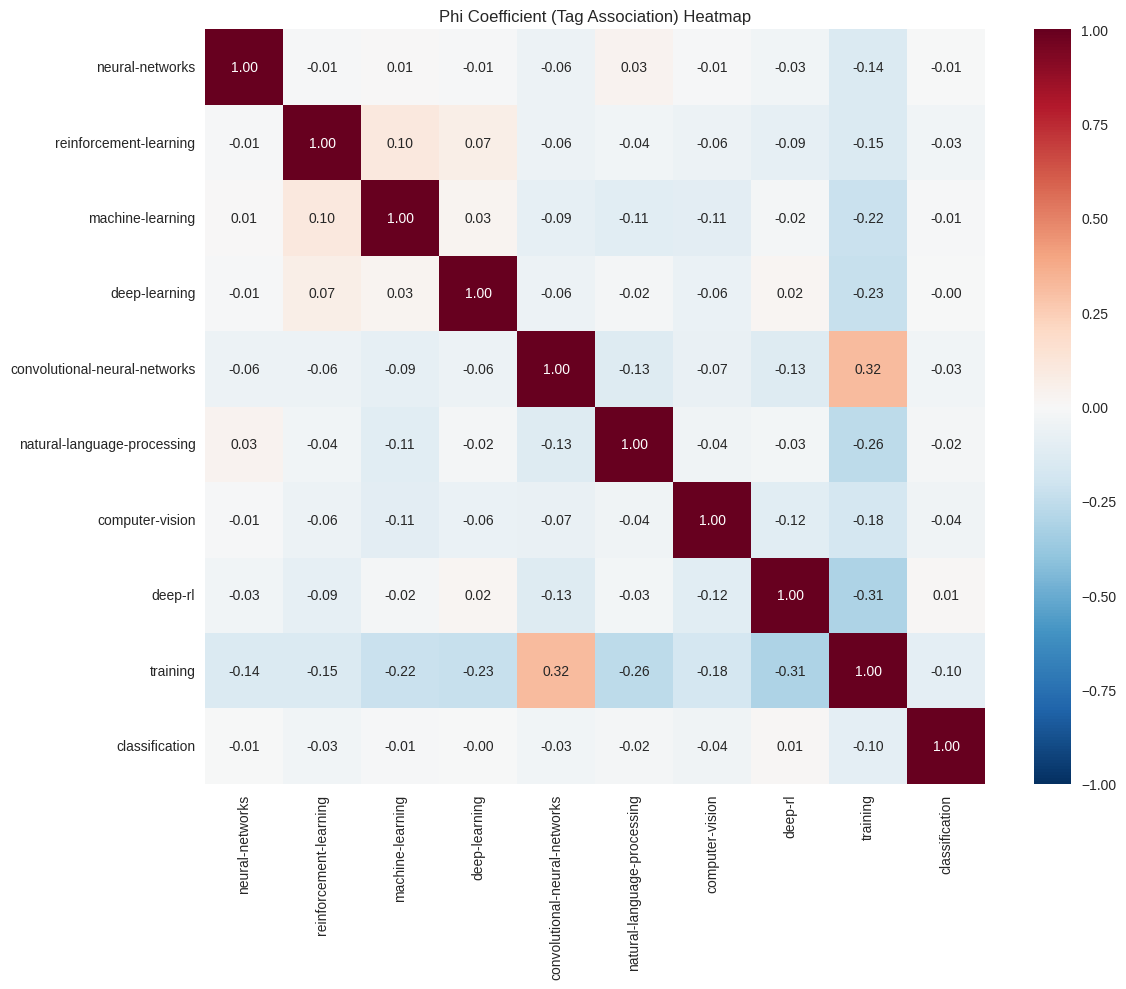

In [101]:
create_heatmap(Y_df)

Some of the values in the phi-coefficient heatmap are not exactly 0, which could motivate some light to moderate co-dependency between some tags. This motivates us to try and employ the use of classifier chains.

In [111]:
from skmultilearn.problem_transform import ClassifierChain

def multilearn_train_eval(X, Y, model, label_names=label_names, test_size=0.2):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
    clf = ClassifierChain(model)
    clf.fit(X_train, Y_train)
    Y_pred = clf.predict(X_test)
    Y_test_dense = Y_test.toarray() if hasattr(Y_test, "toarray") else Y_test
    Y_pred_dense = Y_pred.toarray() if hasattr(Y_pred, "toarray") else Y_pred
    metrics = {
        'f1_macro': f1_score(Y_test, Y_pred, average='macro', zero_division=0),
        'f1_micro': f1_score(Y_test, Y_pred, average='micro', zero_division=0),
        'avg_recall': recall_score(Y_test, Y_pred, average='macro', zero_division=0),
        'avg_precision': precision_score(Y_test, Y_pred, average='macro', zero_division=0),
        'hamming_loss': hamming_loss(Y_test, Y_pred),
        'subset_accuracy': accuracy_score(Y_test, Y_pred)
    }
    if label_names is not None:
        confusion_matrices = multilabel_confusion_matrix(Y_test, Y_pred)
        for i, cm in enumerate(confusion_matrices):
            tn, fp, fn, tp = cm.ravel()
            print(f"\nLabel: {label_names[i]}")
            print(f"[[TN: {tn}, FP: {fp}] [FN: {fn}, TP: {tp}]]")
    return metrics

In [113]:
results = {}

# 1. NAIVE BAYES
print("=" * 50)
print("NAIVE BAYES EVALUATION")
print("=" * 50)

# Naive Bayes for BoW (MultinomialNB)
print("\n1. MultinomialNB on BoW features:")
nb_bow = MultinomialNB()
metrics_nb_bow = multilearn_train_eval(X_bow.drop(columns=['UserId']), Y, nb_bow)
results['NB_BoW'] = metrics_nb_bow
print()
for metric, value in metrics_nb_bow.items():
    print(f"  {metric}: {value:.4f}")
print()
print("-" * 50)
print()

# Naive Bayes for TF-IDF (MultinomialNB)
print("\n2. MultinomialNB on TF-IDF features:")
nb_tfidf = MultinomialNB()
metrics_nb_tfidf = multilearn_train_eval(X_tfidf.drop(columns=['UserId']), Y, nb_tfidf)
results['NB_TFIDF'] = metrics_nb_tfidf
print()
for metric, value in metrics_nb_tfidf.items():
    print(f"  {metric}: {value:.4f}")
print()
print("-" * 50)
print()

# Naive Bayes for SVD (GaussianNB)
print("\n3. GaussianNB on SVD features:")
nb_svd = GaussianNB()
metrics_nb_svd = multilearn_train_eval(X_svd.drop(columns=['UserId']), Y, nb_svd)
results['NB_SVD'] = metrics_nb_svd
print()
for metric, value in metrics_nb_svd.items():
    print(f"  {metric}: {value:.4f}")
print()
print("-" * 50)
print()

NAIVE BAYES EVALUATION

1. MultinomialNB on BoW features:

Label: neural-networks
[[TN: 1671, FP: 14] [FN: 102, TP: 10]]

Label: reinforcement-learning
[[TN: 1666, FP: 27] [FN: 82, TP: 22]]

Label: machine-learning
[[TN: 1493, FP: 58] [FN: 122, TP: 124]]

Label: deep-learning
[[TN: 1288, FP: 107] [FN: 314, TP: 88]]

Label: convolutional-neural-networks
[[TN: 1640, FP: 50] [FN: 81, TP: 26]]

Label: natural-language-processing
[[TN: 1193, FP: 127] [FN: 303, TP: 174]]

Label: computer-vision
[[TN: 1623, FP: 33] [FN: 73, TP: 68]]

Label: deep-rl
[[TN: 1143, FP: 136] [FN: 238, TP: 280]]

Label: training
[[TN: 1281, FP: 40] [FN: 37, TP: 439]]

Label: classification
[[TN: 1676, FP: 15] [FN: 103, TP: 3]]

  f1_macro: 0.4170
  f1_micro: 0.5448
  avg_recall: 0.3605
  avg_precision: 0.5348
  hamming_loss: 0.1147
  subset_accuracy: 0.3038

--------------------------------------------------


2. MultinomialNB on TF-IDF features:

Label: neural-networks
[[TN: 1684, FP: 1] [FN: 110, TP: 2]]

Label: r

In [114]:
# 2. RANDOM FOREST
print("\n" + "=" * 50)
print("RANDOM FOREST EVALUATION")
print("=" * 50)

# Random Forest for BoW
print("\n1. Random Forest on BoW features:")
rf_bow = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
metrics_rf_bow = multilearn_train_eval(X_bow.drop(columns=['UserId']), Y, rf_bow)
results['RF_BoW'] = metrics_rf_bow
print()
for metric, value in metrics_rf_bow.items():
    print(f"  {metric}: {value:.4f}")
print()
print("-"*50)
print()
# Random Forest for TF-IDF
print("\n2. Random Forest on TF-IDF features:")
rf_tfidf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
metrics_rf_tfidf = multilearn_train_eval(X_tfidf.drop(columns=['UserId']), Y, rf_tfidf)
results['RF_TFIDF'] = metrics_rf_tfidf
print()
for metric, value in metrics_rf_tfidf.items():
    print(f"  {metric}: {value:.4f}")
print()
print("-"*50)
print()


RANDOM FOREST EVALUATION

1. Random Forest on BoW features:

Label: neural-networks
[[TN: 1684, FP: 1] [FN: 111, TP: 1]]

Label: reinforcement-learning
[[TN: 1686, FP: 7] [FN: 93, TP: 11]]

Label: machine-learning
[[TN: 1517, FP: 34] [FN: 93, TP: 153]]

Label: deep-learning
[[TN: 1356, FP: 39] [FN: 314, TP: 88]]

Label: convolutional-neural-networks
[[TN: 1690, FP: 0] [FN: 102, TP: 5]]

Label: natural-language-processing
[[TN: 1274, FP: 46] [FN: 329, TP: 148]]

Label: computer-vision
[[TN: 1637, FP: 19] [FN: 61, TP: 80]]

Label: deep-rl
[[TN: 1171, FP: 108] [FN: 176, TP: 342]]

Label: training
[[TN: 1290, FP: 31] [FN: 34, TP: 442]]

Label: classification
[[TN: 1690, FP: 1] [FN: 105, TP: 1]]

  f1_macro: 0.4091
  f1_micro: 0.5987
  avg_recall: 0.3478
  avg_precision: 0.7388
  hamming_loss: 0.0948
  subset_accuracy: 0.3845

--------------------------------------------------


2. Random Forest on TF-IDF features:

Label: neural-networks
[[TN: 1685, FP: 0] [FN: 110, TP: 2]]

Label: reinfo

In [115]:
# 3. K-NEAREST NEIGHBORS with COSINE SIMILARITY

print("\n" + "=" * 50)
print("K-NEAREST NEIGHBORS (KNN) with COSINE SIMILARITY EVALUATION")
print("=" * 50)

from sklearn.neighbors import KNeighborsClassifier

# KNN for BoW
print("\n1. KNN on BoW features:")
knn_bow = KNeighborsClassifier(n_neighbors=5, metric='cosine', algorithm='brute', n_jobs=-1)
metrics_knn_bow = multilearn_train_eval(X_bow.drop(columns=['UserId']), Y, knn_bow)
results['KNN_COSINE_BoW'] = metrics_knn_bow
for metric, value in metrics_knn_bow.items():
    print(f"  {metric}: {value:.4f}")

# KNN for TF-IDF
print("\n2. KNN on TF-IDF features:")
knn_tfidf = KNeighborsClassifier(n_neighbors=5, metric='cosine', algorithm='brute', n_jobs=-1)
metrics_knn_tfidf = multilearn_train_eval(X_tfidf.drop(columns=['UserId']), Y, knn_tfidf)
results['KNN_COSINE_TFIDF'] = metrics_knn_tfidf
for metric, value in metrics_knn_tfidf.items():
    print(f"  {metric}: {value:.4f}")


K-NEAREST NEIGHBORS (KNN) with COSINE SIMILARITY EVALUATION

1. KNN on BoW features:

Label: neural-networks
[[TN: 1680, FP: 5] [FN: 105, TP: 7]]

Label: reinforcement-learning
[[TN: 1679, FP: 14] [FN: 99, TP: 5]]

Label: machine-learning
[[TN: 1519, FP: 32] [FN: 191, TP: 55]]

Label: deep-learning
[[TN: 1287, FP: 108] [FN: 340, TP: 62]]

Label: convolutional-neural-networks
[[TN: 1680, FP: 10] [FN: 98, TP: 9]]

Label: natural-language-processing
[[TN: 1108, FP: 212] [FN: 319, TP: 158]]

Label: computer-vision
[[TN: 1607, FP: 49] [FN: 104, TP: 37]]

Label: deep-rl
[[TN: 1034, FP: 245] [FN: 293, TP: 225]]

Label: training
[[TN: 1157, FP: 164] [FN: 114, TP: 362]]

Label: classification
[[TN: 1687, FP: 4] [FN: 104, TP: 2]]
  f1_macro: 0.2797
  f1_micro: 0.4140
  avg_recall: 0.2380
  avg_precision: 0.4675
  hamming_loss: 0.1452
  subset_accuracy: 0.2732

2. KNN on TF-IDF features:

Label: neural-networks
[[TN: 1680, FP: 5] [FN: 105, TP: 7]]

Label: reinforcement-learning
[[TN: 1661, FP: 3

# 3. Use-case scenario

In [121]:
example_post = "My model is performing poorly. I want to train it better but training it makes me so tired. Perhaps deep learning models could perform better for such tasks."

example_vec = bow_vectorizer.transform([example_post])

rf_bow = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
X_train, X_test, Y_train, Y_test = train_test_split(X_bow.drop(columns=['UserId']), Y, test_size=0.2, random_state=42)
rf_bow.fit(X_train, Y_train)

predicted_tags_binary = rf_bow.predict(example_vec)

predicted_tags_array = predicted_tags_binary.toarray()[0] if hasattr(predicted_tags_binary, "toarray") else predicted_tags_binary[0]

predicted_tags = [label_names[i] for i, val in enumerate(predicted_tags_array) if val == 1]

print("Predicted tags: ", predicted_tags)


/home/bojan/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Predicted tags:  ['deep-learning']
